Dataset loaded: 54335 images, 38 classes.
Data split: 32328 train, 13856 validation, 8151 test.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 92.6MB/s]


VGG16 model loaded. Using device: cuda

Starting training with augmentation...
Epoch : 1/10 Train_loss:1.320 Validation_loss:0.423 Duration:0:07:13.847246
Epoch : 2/10 Train_loss:0.977 Validation_loss:0.364 Duration:0:06:43.302168
Epoch : 3/10 Train_loss:0.900 Validation_loss:0.358 Duration:0:06:43.884983
Epoch : 4/10 Train_loss:0.879 Validation_loss:0.331 Duration:0:06:39.115060
Epoch : 5/10 Train_loss:0.849 Validation_loss:0.309 Duration:0:06:40.963460
Epoch : 6/10 Train_loss:0.839 Validation_loss:0.298 Duration:0:06:40.990066
Epoch : 7/10 Train_loss:0.824 Validation_loss:0.292 Duration:0:06:38.859429
Epoch : 8/10 Train_loss:0.824 Validation_loss:0.286 Duration:0:06:37.805993
Epoch : 9/10 Train_loss:0.811 Validation_loss:0.281 Duration:0:06:41.586784
Epoch : 10/10 Train_loss:0.786 Validation_loss:0.280 Duration:0:06:46.873493
Training complete.
Loss plot saved to /content/vgg16_loss_plot_augmented.png

Calculating final accuracy...
Train Accuracy : 81.79%
Test Accuracy : 91.41%
Valid

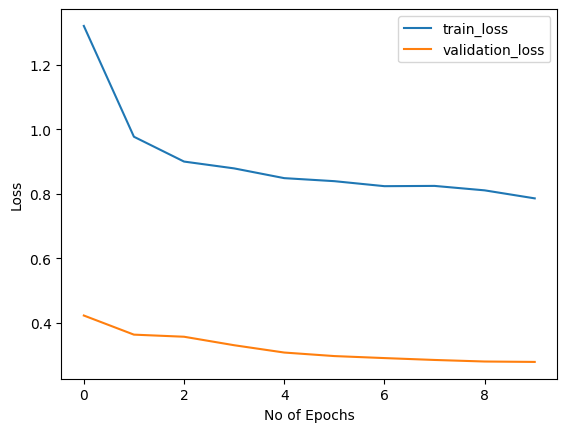

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from datetime import datetime
import os


DATASET_DIR = "/content/PlantVillage-Dataset/raw/color/"
MODEL_SAVE_PATH = "/content/plant_disease_vgg16_augmented.pt"
PLOT_SAVE_PATH = "/content/vgg16_loss_plot_augmented.png"


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(30),           
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    
])


val_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),

])

try:
    train_dataset = datasets.ImageFolder(DATASET_DIR, transform=train_transform)
    val_dataset = datasets.ImageFolder(DATASET_DIR, transform=val_transform)
    test_dataset = datasets.ImageFolder(DATASET_DIR, transform=val_transform)

    targets_size = len(train_dataset.class_to_idx)
    print(f"Dataset loaded: {len(train_dataset)} images, {targets_size} classes.")

except FileNotFoundError:
    print(f"Error: 'Dataset' folder not found at {DATASET_DIR}")
    print("Please make sure you ran the !git clone cell first.")
    raise


indices = list(range(len(train_dataset)))
np.random.shuffle(indices)

split = int(np.floor(0.85 * len(train_dataset)))
validation_split_point = int(np.floor(0.70 * split))

train_indices = indices[:validation_split_point]
validation_indices = indices[validation_split_point:split]
test_indices = indices[split:]

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler
)
validation_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, sampler=validation_sampler
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, sampler=test_sampler
)

print(f"Data split: {len(train_indices)} train, {len(validation_indices)} validation, {len(test_indices)} test.")


# --- 4. LOAD VGG16 & REPLACE CLASSIFIER ---
model = models.vgg16(pretrained=True)

# Freeze convolutional layers
for param in model.parameters():
    param.requires_grad = False


n_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, targets_size),  
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"VGG16 model loaded. Using device: {device}")

# --- 5. DEFINE LOSS, OPTIMIZER, & TRAIN FUNCTION ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

def batch_gd(model, criterion, optimizer, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        model.train() # Set model to training mode
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        train_loss = np.mean(train_loss)

        validation_loss = []
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                loss = criterion(output, targets)
                validation_loss.append(loss.item())
        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss
        dt = datetime.now() - t0
        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Validation_loss:{validation_loss:.3f} Duration:{dt}"
        )
    return train_losses, validation_losses

# --- 6. DEFINE ACCURACY FUNCTION ---
def accuracy(loader, model):
    n_correct = 0
    n_total = 0
    model.eval()
    with torch.no_grad():
        for inputs , targets in loader:
            inputs , targets = inputs.to(device) , targets.to(device)
            outputs = model(inputs)
            _ , predictions = torch.max(outputs, 1)
            n_correct += (predictions == targets).sum().item()
            n_total += targets.shape[0]
    return n_correct / n_total

# --- 7. RUN TRAINING ---
print("\nStarting training with augmentation...")
epochs = 10
train_losses, validation_losses = batch_gd(
    model, criterion, optimizer, train_loader, validation_loader, epochs
)
print("Training complete.")

# --- 8. PLOT LOSS & SAVE ---
plt.figure()
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(PLOT_SAVE_PATH)
print(f"Loss plot saved to {PLOT_SAVE_PATH}")

# --- 9. CALCULATE ACCURACY & SAVE MODEL ---
print("\nCalculating final accuracy...")
train_acc = accuracy(train_loader, model)
test_acc = accuracy(test_loader, model)
validation_acc = accuracy(validation_loader, model)

print(
    f"Train Accuracy : {train_acc*100:.2f}%\n"
    f"Test Accuracy : {test_acc*100:.2f}%\n"
    f"Validation Accuracy : {validation_acc*100:.2f}%"
)

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"New augmented model saved to {MODEL_SAVE_PATH}")
print("You can now download this new .pt file from the Colab file browser (left sidebar).")